# K-Means Clustering - Swiss Hiking Trails

This notebook performs k-means clustering of Swiss hiking trails to group similar routes.

**Goals:**
- Load, clean and prepare data
- Determine optimal number of clusters
- Perform and interpret K-Means clustering

## 1. Setup & Load Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from notebooks.utils.db_utils import read_from_db
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Load data from CSV dump
df = read_from_db("SELECT * FROM hiking_routes")

print(f"Dataset Shape: {df.shape}")
df.head()

Loaded 375 rows, 13 columns from database
Dataset Shape: (375, 13)


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Data Cleaning and Feature Selection

In [3]:
# Data cleaning: Remove rows with missing critical values
df_clean = df.copy()

print(f"Before cleaning: {len(df_clean)} rows")

# Remove rows with missing or invalid coordinates
df_clean = df_clean[(df_clean['latitude'] != 0) & (df_clean['longitude'] != 0)]
df_clean = df_clean[df_clean['latitude'].notna() & df_clean['longitude'].notna()]

# Remove rows with missing basic metrics
df_clean = df_clean[df_clean['duration_min'] > 0]
df_clean = df_clean[df_clean['distance_km'] > 0]

print(f"After cleaning: {len(df_clean)} rows")
print(f"Removed: {len(df) - len(df_clean)} rows ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

Before cleaning: 375 rows
After cleaning: 339 rows
Removed: 36 rows (9.6%)


In [4]:
# Feature selection for clustering
clustering_features = ['duration_min', 'distance_km', 'ascent_m', 'descent_m']
X = df_clean[clustering_features].copy()

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"\nFeature Statistics:")
print(X.describe())


Feature Matrix Shape: (339, 4)

Feature Statistics:
       duration_min  distance_km  ascent_m  descent_m
count        339.00       339.00    339.00     339.00
mean         181.24         8.82    313.58     347.65
std           74.35         3.70    187.66     219.66
min           35.00         1.60      5.00      10.00
25%          130.00         5.90    175.00     190.00
50%          175.00         8.40    290.00     315.00
75%          220.00        11.15    417.50     460.00
max          435.00        24.30   1080.00    1310.00


## 3. Feature Scaling

In [5]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4. Determine Optimal Number of Clusters

In [6]:
# Calculate metrics for different k values
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Calculating clustering metrics for different k values...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

Calculating clustering metrics for different k values...
k=2: Silhouette=0.408, Davies-Bouldin=0.962
k=3: Silhouette=0.330, Davies-Bouldin=1.056
k=4: Silhouette=0.276, Davies-Bouldin=1.180
k=5: Silhouette=0.296, Davies-Bouldin=1.060
k=6: Silhouette=0.276, Davies-Bouldin=1.175
k=7: Silhouette=0.296, Davies-Bouldin=1.029
k=8: Silhouette=0.282, Davies-Bouldin=1.065
k=9: Silhouette=0.295, Davies-Bouldin=0.992
k=10: Silhouette=0.314, Davies-Bouldin=1.028


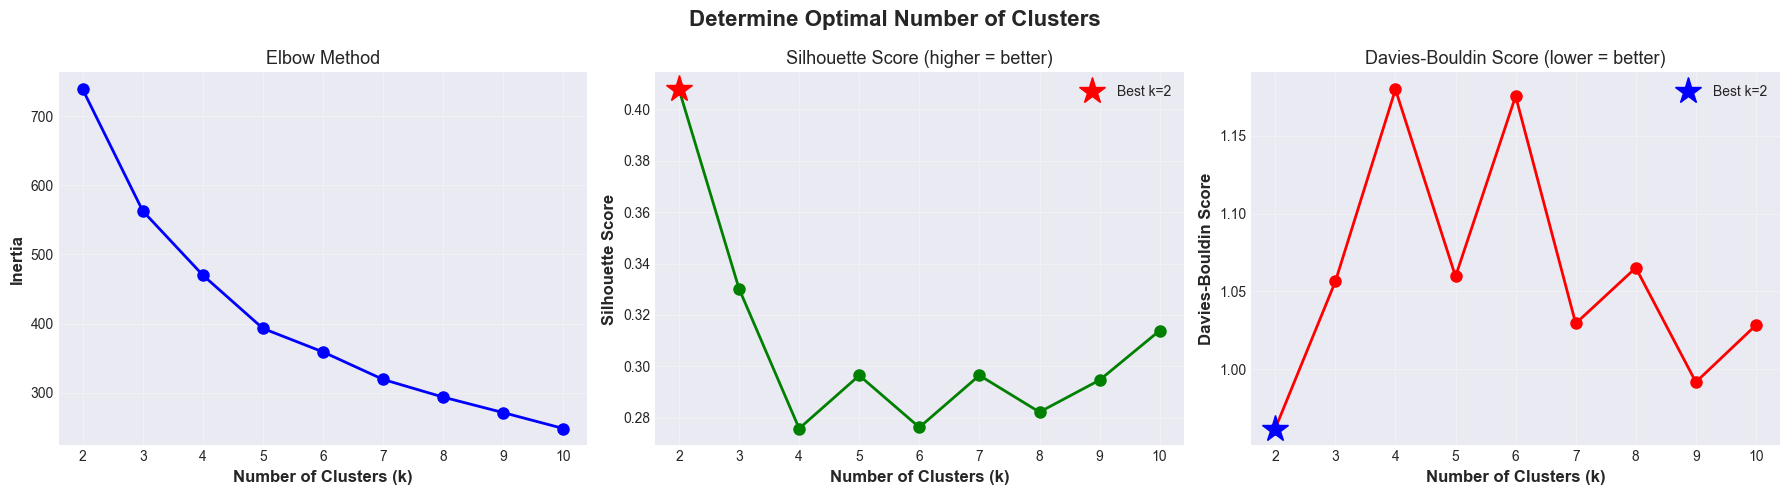


Recommendation: k = 2 (based on highest Silhouette Score)


In [7]:
# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Determine Optimal Number of Clusters', fontsize=16, fontweight='bold')

# 1. Elbow Method (Inertia)
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 2. Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score (higher = better)', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
max_idx = np.argmax(silhouette_scores)
axes[1].plot(list(k_range)[max_idx], silhouette_scores[max_idx], 'r*', markersize=20, label=f'Best k={list(k_range)[max_idx]}')
axes[1].legend()

# 3. Davies-Bouldin Score
axes[2].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12, fontweight='bold')
axes[2].set_title('Davies-Bouldin Score (lower = better)', fontsize=13)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)
min_idx = np.argmin(davies_bouldin_scores)
axes[2].plot(list(k_range)[min_idx], davies_bouldin_scores[min_idx], 'b*', markersize=20, label=f'Best k={list(k_range)[min_idx]}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Recommendation
best_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]
print(f"\nRecommendation: k = {best_k_silhouette} (based on highest Silhouette Score)")

## 5. Perform K-Means Clustering

In [8]:
# K-Means with optimal k
optimal_k = best_k_silhouette

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_clean['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"K-MEANS CLUSTERING RESULTS (k = {optimal_k})")
print(f"\nCluster Distribution:")
print(df_clean['cluster'].value_counts().sort_index())
print(f"\nCluster Sizes (Percent):")
print((df_clean['cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

K-MEANS CLUSTERING RESULTS (k = 2)

Cluster Distribution:
cluster
0    218
1    121
Name: count, dtype: int64

Cluster Sizes (Percent):
cluster
0   64.31
1   35.69
Name: proportion, dtype: float64



CLUSTER CENTROIDS (Original Scale)
           duration_min  distance_km  ascent_m  descent_m
Cluster 0        139.47         7.00    224.13     244.17
Cluster 1        256.49        12.11    474.75     534.09


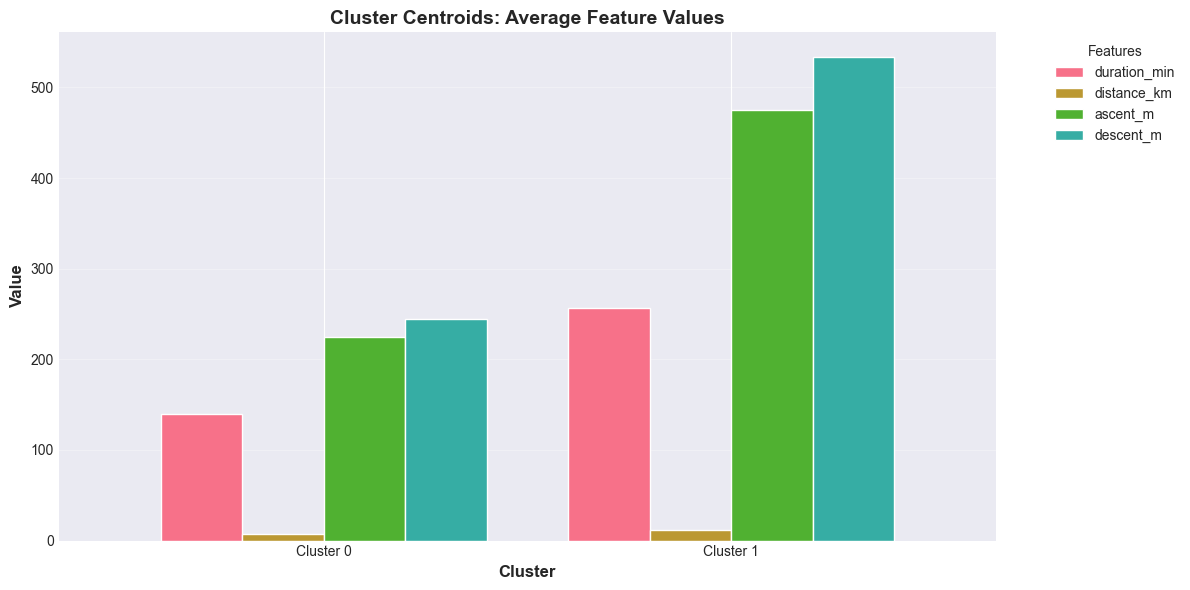

In [9]:
# Cluster centroids (transformed back to original scale)
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=clustering_features)
centroids_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\nCLUSTER CENTROIDS (Original Scale)")
print(centroids_df)

# Visualize centroids
fig, ax = plt.subplots(figsize=(12, 6))
centroids_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Cluster Centroids: Average Feature Values', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Value', fontsize=12, fontweight='bold')
ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Cluster Characterization

In [10]:
# Create cluster labels based on characteristics
cluster_labels = {}

for cluster_id in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    avg_duration = cluster_data['duration_min'].mean()
    avg_distance = cluster_data['distance_km'].mean()
    avg_ascent = cluster_data['ascent_m'].mean()
    
    # Create descriptive label
    if avg_duration < 120 and avg_distance < 5:
        label = "Short Hikes"
    elif avg_duration < 240 and avg_distance < 10:
        label = "Medium Hikes"
    elif avg_ascent > 800:
        label = "Mountain Tours (high ascent)"
    elif avg_distance > 15:
        label = "Long Distance"
    else:
        label = "Challenging Tours"

    cluster_labels[cluster_id] = label

print("CLUSTER LABELS")
print("="*80)
for cluster_id, label in cluster_labels.items():
    count = len(df_clean[df_clean['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {label} ({count} hiking trails)")
    print(f"Average: {centroids_df.loc[f'Cluster {cluster_id}'].to_dict()}")
    print()

CLUSTER LABELS
Cluster 0: Medium Hikes (218 hiking trails)
Average: {'duration_min': 139.47247706422016, 'distance_km': 6.998623853211009, 'ascent_m': 224.12844036697243, 'descent_m': 244.17431192660553}

Cluster 1: Challenging Tours (121 hiking trails)
Average: {'duration_min': 256.4876033057851, 'distance_km': 12.1099173553719, 'ascent_m': 474.7520661157025, 'descent_m': 534.0909090909091}



## 7. Main Visualization

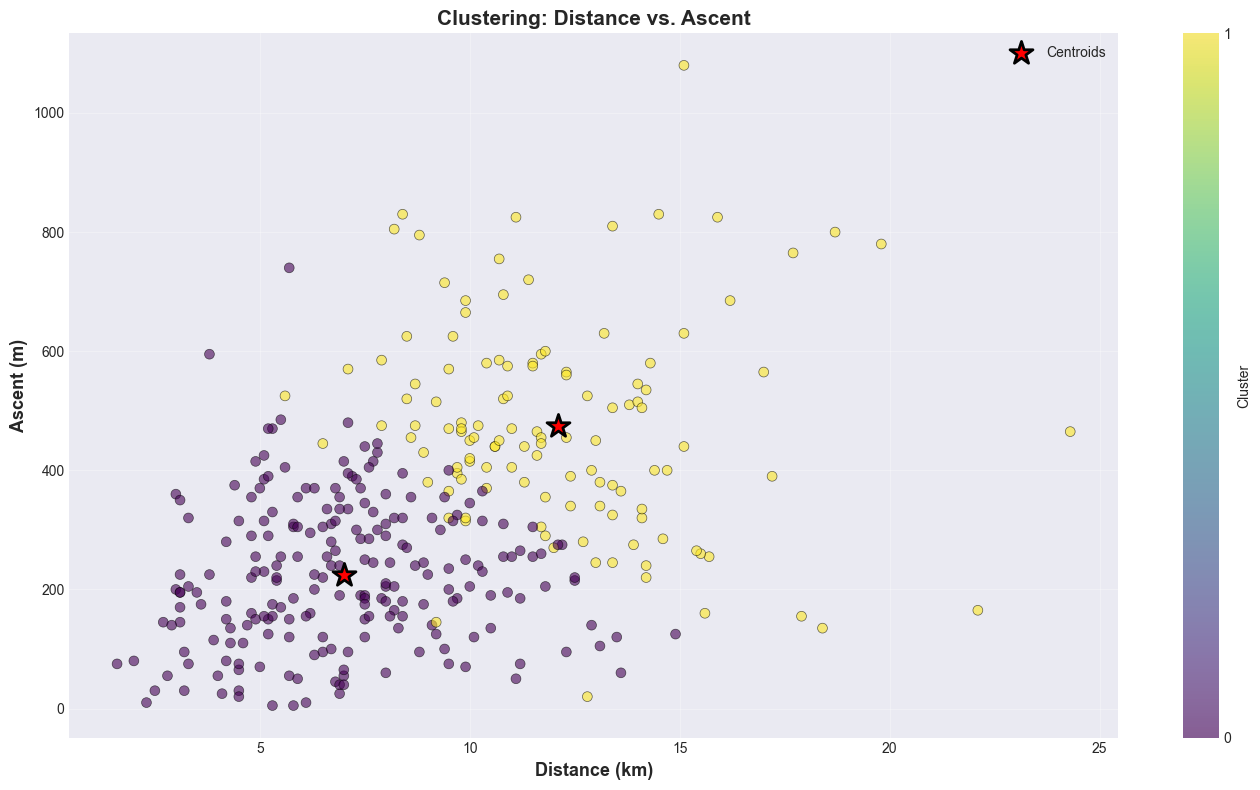

In [11]:
# Scatter Plot: Distance vs. Ascent, colored by cluster
plt.figure(figsize=(14, 8))

scatter = plt.scatter(df_clean['distance_km'], 
                     df_clean['ascent_m'],
                     c=df_clean['cluster'],
                     cmap='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

plt.xlabel('Distance (km)', fontsize=13, fontweight='bold')
plt.ylabel('Ascent (m)', fontsize=13, fontweight='bold')
plt.title('Clustering: Distance vs. Ascent', fontsize=15, fontweight='bold')
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
plt.grid(True, alpha=0.3)

# Add cluster centroids
plt.scatter(centroids_df['distance_km'],
           centroids_df['ascent_m'],
           c='red',
           s=300,
           marker='*',
           edgecolors='black',
           linewidth=2,
           label='Centroids')

plt.legend()
plt.tight_layout()
plt.show()

## 8. Cluster Evaluation

In [12]:
# Final evaluation metrics
final_silhouette = silhouette_score(X_scaled, df_clean['cluster'])
final_davies_bouldin = davies_bouldin_score(X_scaled, df_clean['cluster'])
final_inertia = kmeans_final.inertia_

print("="*80)
print("FINAL CLUSTER EVALUATION")
print("="*80)
print(f"\nNumber of Clusters: {optimal_k}")
print(f"Number of Data Points: {len(df_clean)}")
print(f"\nQuality Metrics:")
print(f"- Silhouette Score: {final_silhouette:.4f} (range: -1 to 1, higher = better)")
print(f"- Davies-Bouldin Score: {final_davies_bouldin:.4f} (lower = better)")
print(f"- Inertia: {final_inertia:.2f}")

# Interpretation
print(f"\nInterpretation:")
if final_silhouette > 0.5:
    print("Silhouette Score > 0.5: Good cluster separation")
elif final_silhouette > 0.25:
    print("Silhouette Score 0.25-0.5: Acceptable cluster structure")
else:
    print("Silhouette Score < 0.25: Weak cluster structure")

print("="*80)

FINAL CLUSTER EVALUATION

Number of Clusters: 2
Number of Data Points: 339

Quality Metrics:
- Silhouette Score: 0.4078 (range: -1 to 1, higher = better)
- Davies-Bouldin Score: 0.9620 (lower = better)
- Inertia: 738.41

Interpretation:
Silhouette Score 0.25-0.5: Acceptable cluster structure


## 10. Summary

The K-Means analysis has grouped Swiss hiking trails into clusters with similar characteristics.

**Features Used:** Duration, Distance, Ascent, Descent

**Use Cases:**
- Recommendation system for similar routes
- Route planning by difficulty level
- Analysis of hiking trail characteristics
